# **Modeling and Evaluation Notebook**

## Objectives

- Answer business requirement 1:
    -  Detect mildew in cherry leaves using image data.

## Inputs

- Cherry leaf dataset directories for train, validation, and test images, organized by class path: /workspace/pp5_cherry_leaves_mildew_detection/inputs/cherry_leaves_dataset/cherry-leaves
- Image shape embeddings for consistent model input sizing across datasets

## Outputs

- Distribution plots of images in train, validation, and test sets
- Augmented image samples to visualize preprocessing
- Saved trained model file
- Learning curves displaying loss and accuracy across epochs
- Evaluation metrics saved in a pickle format for easy retrieval
- Predictions with probability scores on random test images

## Additional Comments

- No additional comments.

---

# Setup

## Import Libraries and Set Directory Paths

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import joblib
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import MobileNetV2  # Alternative model
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image


## Set Up Paths and Parameters

In [5]:
import os

# Define the working directory and input paths for train, validation, and test sets
data_dir = '/workspace/pp5_cherry_leaves_mildew_detection/inputs/cherry_leaves_dataset/cherry-leaves'
train_path = os.path.join(data_dir, 'train')
val_path = os.path.join(data_dir, 'validation')
test_path = os.path.join(data_dir, 'test')

# Retrieve labels from the subdirectories in the training directory
labels = os.listdir(train_path)

# Check for existing output directory, if not create one
version = 'v1'
output_dir = f'outputs/{version}'
os.makedirs(output_dir, exist_ok=True)

print(f"Project Labels: {labels}")


Project Labels: ['healthy', 'powdery_mildew']


### Set Image Schape

Define a sample image shape by loading one sample image

In [6]:
sample_img = imread(os.path.join(train_path, labels[0], os.listdir(os.path.join(train_path, labels[0]))[0]))
image_shape = sample_img.shape

# Save image shape for future reference
joblib.dump(image_shape, filename=f"{output_dir}/image_shape.pkl")
print("Image shape:", image_shape)

Image shape: (256, 256, 3)


### Count images in train, validation, and test directories

* train - healthy: 1472 images
* train - powdery_mildew: 1472 images
* validation - healthy: 210 images
* validation - powdery_mildew: 210 images
* test - healthy: 422 images
* test - powdery_mildew: 422 images


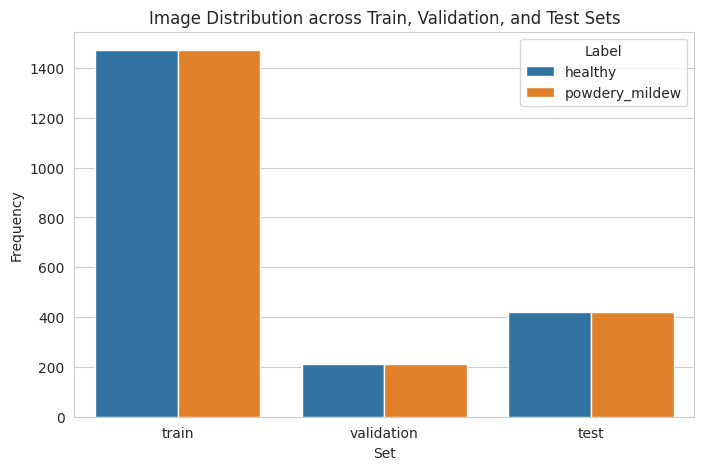

In [7]:
df_freq = pd.DataFrame([]) 
for folder in ['train', 'validation', 'test']:
    for label in labels:
        count = len(os.listdir(os.path.join(data_dir, folder, label)))
        df_freq = df_freq.append(pd.Series({'Set': folder, 'Label': label, 'Frequency': count}), ignore_index=True)
        print(f"* {folder} - {label}: {count} images")

# Plot the distribution of images
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.title("Image Distribution across Train, Validation, and Test Sets")
plt.savefig(f'{output_dir}/labels_distribution.png', bbox_inches='tight', dpi=150)
plt.show()

### Image Augmentation

In [8]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10, 
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255)

batch_size = 20  # Set batch size

# Augment training image dataset
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True)

# Augment validation image dataset
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False)

# Augment test image dataset
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False)

# Save class indices for reference
joblib.dump(train_set.class_indices, filename=f"{output_dir}/class_indices.pkl")
print("Class indices:", train_set.class_indices)

Found 2944 images belonging to 2 classes.
Found 420 images belonging to 2 classes.
Found 844 images belonging to 2 classes.
Class indices: {'healthy': 0, 'powdery_mildew': 1}


## Model Creation

In [9]:
def create_tf_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=image_shape, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = create_tf_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 57600)             0

2024-12-04 11:38:05.813427: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Train the Model

In [10]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(train_set,
                    epochs=25,
                    steps_per_epoch=len(train_set),
                    validation_data=validation_set,
                    callbacks=[early_stop],
                    verbose=1)

2024-12-04 11:38:06.200236: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25
148/148 [==============================] - 303s 2s/step - loss: 0.3097 - accuracy: 0.8614 - val_loss: 0.0947 - val_accuracy: 0.9857
Epoch 2/25
148/148 [==============================] - 292s 2s/step - loss: 0.1137 - accuracy: 0.9688 - val_loss: 0.0141 - val_accuracy: 0.9976
Epoch 3/25
148/148 [==============================] - 292s 2s/step - loss: 0.0405 - accuracy: 0.9891 - val_loss: 0.0052 - val_accuracy: 1.0000
Epoch 4/25
148/148 [==============================] - 292s 2s/step - loss: 0.0554 - accuracy: 0.9837 - val_loss: 0.0821 - val_accuracy: 0.9690
Epoch 5/25
148/148 [==============================] - 290s 2s/step - loss: 0.0310 - accuracy: 0.9881 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 6/25
148/148 [==============================] - 294s 2s/step - loss: 0.0375 - accuracy: 0.9905 - val_loss: 0.0076 - val_accuracy: 0.9976
Epoch 7/25
148/148 [==============================] - 293s 2s/step - loss: 0.0250 - accuracy: 0.9946 - val_loss: 0.0033 - val_accuracy: 0.9976

### Save Model

In [11]:
model.save('outputs/model/v1/your_trained_model.h5')

### Plot Training History

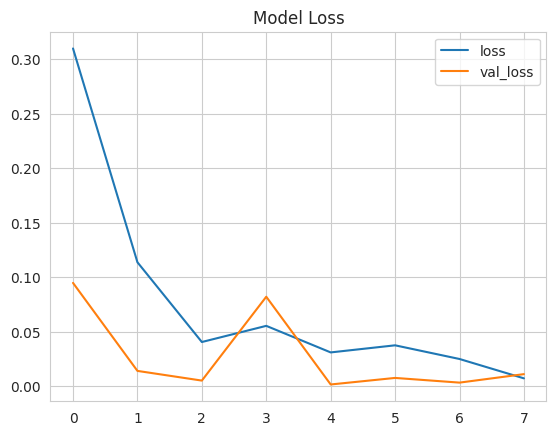

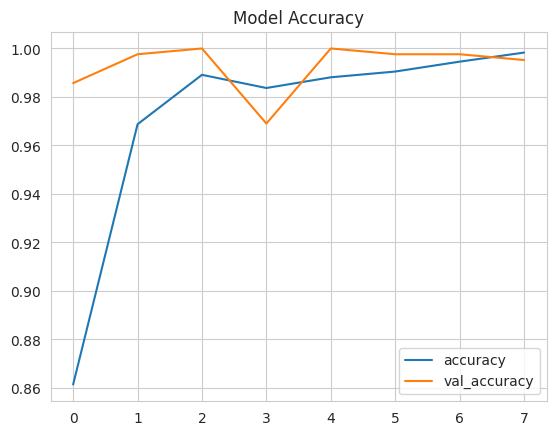

In [12]:

# Loss plot
loss_df = pd.DataFrame(history.history)
sns.set_style("whitegrid")
loss_df[['loss', 'val_loss']].plot()
plt.title("Model Loss")
plt.savefig(f'{output_dir}/model_loss_plot.png', bbox_inches='tight', dpi=150)
plt.show()

# Accuracy plot
loss_df[['accuracy', 'val_accuracy']].plot()
plt.title("Model Accuracy")
plt.savefig(f'{output_dir}/model_accuracy_plot.png', bbox_inches='tight', dpi=150)
plt.show()

### Evaluate Model on Test Set

In [13]:
evaluation = model.evaluate(test_set)
joblib.dump(evaluation, filename=f"{output_dir}/model_evaluation.pkl")
print(f"Test loss: {evaluation[0]}, Test accuracy: {evaluation[1]}")

43/43 [==============================] - 18s 421ms/step - loss: 0.0093 - accuracy: 0.9953
Test loss: 0.009282455779612064, Test accuracy: 0.9952606558799744


### Predict on a Random Test Image

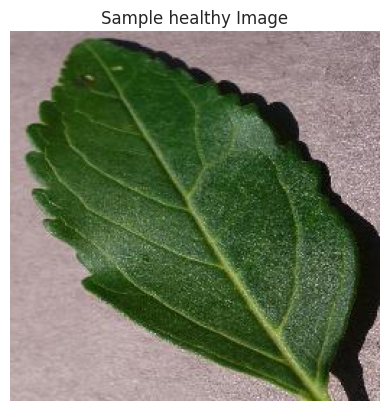

Prediction: healthy with probability 2.5507217742415378e-06


In [14]:
label = labels[0]  # Choose a label, e.g., 'healthy'
sample_image = image.load_img(os.path.join(test_path, label, os.listdir(os.path.join(test_path, label))[0]),
                              target_size=image_shape[:2])
plt.imshow(sample_image)
plt.axis('off')
plt.title(f"Sample {label} Image")
plt.show()

# Convert image to array for prediction
sample_image_array = image.img_to_array(sample_image)
sample_image_array = np.expand_dims(sample_image_array, axis=0) / 255

# Predict class
pred_proba = model.predict(sample_image_array)[0, 0]
target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[int(pred_proba > 0.5)]
print(f"Prediction: {pred_class} with probability {pred_proba}")

---

## Debugging Predictions for Mildew-Affected Images

Number of mildew-affected images: 422
Correct predictions for mildew: 418

Classification Report:
                precision    recall  f1-score   support

       healthy       0.99      1.00      1.00       422
powdery_mildew       1.00      0.99      1.00       422

      accuracy                           1.00       844
     macro avg       1.00      1.00      1.00       844
  weighted avg       1.00      1.00      1.00       844



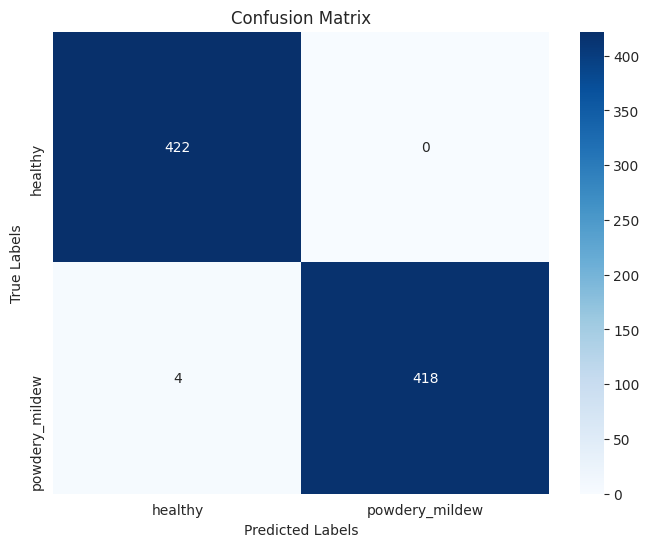

Confusion Matrix saved at: outputs/v1/confusion_matrix.png
Accuracy: 1.00
Number of misclassified images: 4


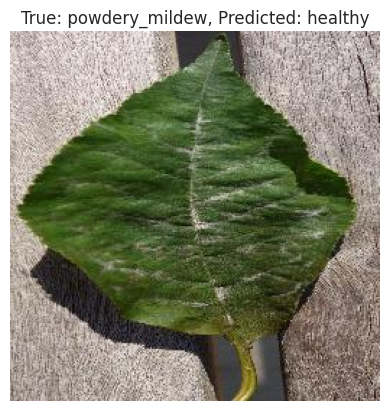

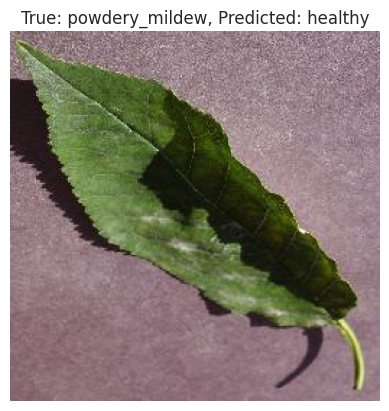

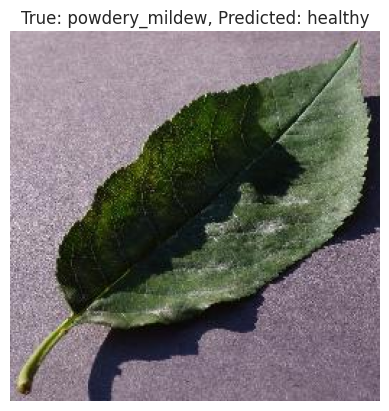

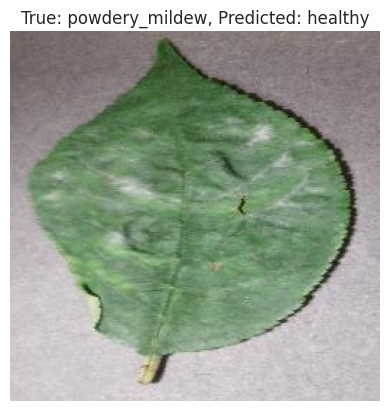

In [15]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

# Prepare test set predictions
test_labels = test_set.classes
test_filenames = test_set.filenames

# Get predictions
predictions = model.predict(test_set)
predicted_classes = (predictions > 0.5).astype(int).flatten()  # Threshold at 0.5

# Map predicted classes back to labels
class_indices = test_set.class_indices
target_map = {v: k for k, v in class_indices.items()}
ground_truth_labels = [target_map[label] for label in test_labels]
predicted_labels = [target_map[cls] for cls in predicted_classes]

# Debug mildew predictions
mildew_indices = [i for i, label in enumerate(ground_truth_labels) if label == "powdery_mildew"]
mildew_ground_truth = [ground_truth_labels[i] for i in mildew_indices]
mildew_predictions = [predicted_labels[i] for i in mildew_indices]

print(f"Number of mildew-affected images: {len(mildew_indices)}")
print(f"Correct predictions for mildew: {sum(1 for i in mildew_indices if predicted_labels[i] == 'powdery_mildew')}")

# Evaluate Performance
print("\nClassification Report:")
print(classification_report(ground_truth_labels, predicted_labels))

# Confusion Matrix: Display and Save
cm = confusion_matrix(ground_truth_labels, predicted_labels, labels=list(target_map.values()))

# Set up output directory
output_dir = 'outputs/v1'
os.makedirs(output_dir, exist_ok=True)  # Ensure the directory exists
conf_matrix_path = os.path.join(output_dir, 'confusion_matrix.png')

# Plot and save the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=list(target_map.values()), yticklabels=list(target_map.values()))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

# Save the plot
plt.savefig(conf_matrix_path, bbox_inches='tight')
plt.show()
plt.close()

print(f"Confusion Matrix saved at: {conf_matrix_path}")

# Accuracy
accuracy = accuracy_score(ground_truth_labels, predicted_labels)
print(f"Accuracy: {accuracy:.2f}")

# Debugging Misclassified Images
misclassified_indices = [i for i in range(len(test_filenames)) if ground_truth_labels[i] != predicted_labels[i]]
print(f"Number of misclassified images: {len(misclassified_indices)}")

# Visualizing Misclassified Mildew Images
for idx in misclassified_indices[:5]:  # Show 5 examples
    if ground_truth_labels[idx] == "powdery_mildew":
        img_path = os.path.join(test_path, test_filenames[idx])
        img = image.load_img(img_path, target_size=image_shape[:2])
        plt.imshow(img)
        plt.title(f"True: {ground_truth_labels[idx]}, Predicted: {predicted_labels[idx]}")
        plt.axis("off")
        plt.show()